## Time dependent Bayesian Optimization

In this example we demonstrate time dependent optimization. In this case we are not
only interested in finding an optimum point in input space, but also maintain the
ideal point over time.

In [1]:
# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")
N_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20

from xopt.generators.bayesian.upper_confidence_bound import TDUpperConfidenceBoundGenerator
from xopt.vocs import VOCS
from xopt.evaluator import Evaluator
import warnings
warnings.filterwarnings("ignore")

### Time dependent test problem
Optimization is carried out over a single variable `x`. The test function is a simple
 quadratic, with a minimum location that drifts in the positive `x` direction over
 (real) time.

In [2]:
# test evaluate function and vocs
import time
from xopt import Xopt

start_time = time.time()
def f(inputs):
    x_ = inputs["x"]
    current_time = time.time()
    t_ = current_time - start_time
    y_ = 5*(x_ - t_*1e-2)**2
    return {"y":y_, "time":current_time}

variables = {"x":[-1,1]}
objectives = {"y": "MINIMIZE"}

vocs = VOCS(variables=variables, objectives=objectives)
print(vocs)

evaluator = Evaluator(function=f)
generator = TDUpperConfidenceBoundGenerator(vocs=vocs)
generator.added_time=1.0
generator.beta = 2.0
generator.n_monte_carlo_samples = N_MC_SAMPLES
generator.numerical_optimizer.n_restarts = NUM_RESTARTS

X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
X

variables={'x': [-1.0, 1.0]} constraints={} objectives={'y': 'MINIMIZE'} constants={} observables=[]



            Xopt
________________________________
Version: 0+untagged.1.gfcbdd82
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: __main__.f
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  added_time: 1.0
  beta: 2.0
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: time_dependent
    trainable_mean_keys: []
    use_low_noise_prior: true
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: time_dependent_upper_confidence_bound
  numerical_optimizer:
    max_iter: 2000
    max_time: null
    n_restarts: 20
    name: LBFGS
  target_prediction_time: null
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants: {}
  constraints: {}
  objectives:
    y: MINIMIZE
  observables: [

In [3]:
X.random_evaluate(1)

for _ in range(20):
    # note that in this example we can ignore warnings if computation time is greater
    # than added time
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        X.step()
        time.sleep(0.1)

print(X.generator.generate(1))

[{'x': 0.20429992914815795}]


In [4]:
X.data

,x,y,time,xopt_runtime,xopt_error
0,0.966771,4.668654,1.706219e+09,0.000016,False
1,-1.000000,5.105634,1.706219e+09,0.000006,False
2,0.329636,0.474592,1.706219e+09,0.000005,False
3,-0.061685,0.044425,1.706219e+09,0.000005,False
4,0.222256,0.159574,1.706219e+09,0.000005,False
5,-0.087894,0.101581,1.706219e+09,0.000006,False
6,0.060630,0.000127,1.706219e+09,0.000006,False
7,0.162345,0.036669,1.706219e+09,0.000005,False
8,0.013036,0.027901,1.706219e+09,0.000005,False
9,0.120794,0.002427,1.706219e+09,0.000005,False


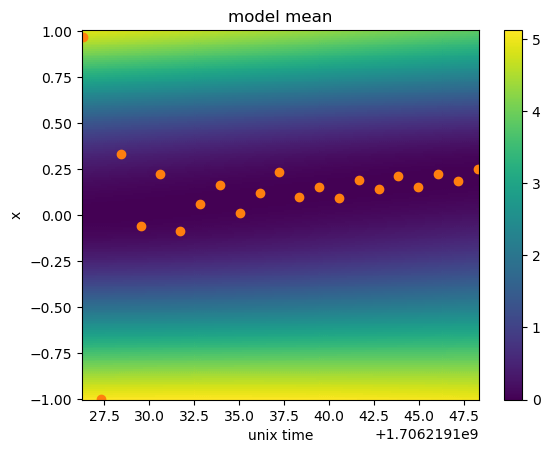

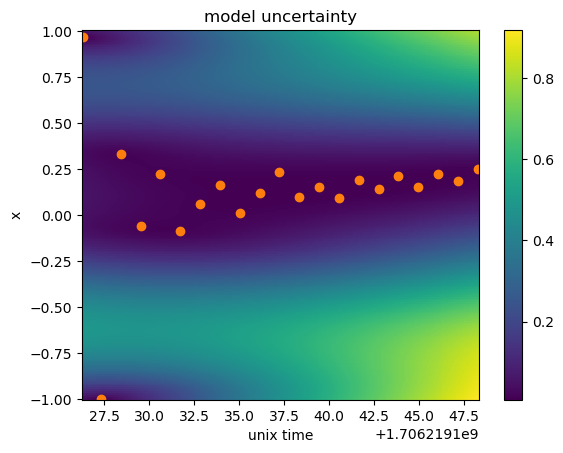

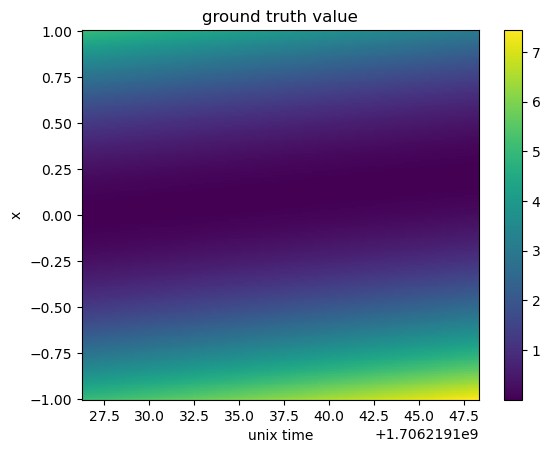

In [5]:
# plot model
import torch
from matplotlib import pyplot as plt  # plot model predictions
data = X.data

xbounds = generator.vocs.bounds
tbounds = [data["time"].min(), data["time"].max()]

def gt(inpts):
    return 5*(inpts[:,1] - (inpts[:,0] - start_time)*1e-2)**2

model = X.generator.model
n = 200
t = torch.linspace(*tbounds, n, dtype=torch.double)
x = torch.linspace(*xbounds.flatten(), n, dtype=torch.double)
tt, xx = torch.meshgrid(t, x)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (tt, xx)]).double()

tt, xx = tt.numpy(), xx.numpy()

#NOTE: the model inputs are such that t is the last dimension
gp_pts = torch.flip(pts, dims=[-1])

gt_vals = gt(pts)

with torch.no_grad():
    post = model.posterior(gp_pts)

    mean = post.mean
    std = torch.sqrt(post.variance)

    fig, ax = plt.subplots()
    ax.set_title("model mean")
    ax.set_xlabel("unix time")
    ax.set_ylabel("x")
    c = ax.pcolor(tt, xx, mean.reshape(n,n))
    fig.colorbar(c)

    fig2, ax2 = plt.subplots()
    ax2.set_title("model uncertainty")
    ax2.set_xlabel("unix time")
    ax2.set_ylabel("x")
    c = ax2.pcolor(tt, xx, std.reshape(n,n))
    fig2.colorbar(c)

    ax.plot(data["time"].to_numpy(), data["x"].to_numpy(),"oC1")
    ax2.plot(data["time"].to_numpy(), data["x"].to_numpy(),"oC1")

    fig3, ax3 = plt.subplots()
    ax3.set_title("ground truth value")
    ax3.set_xlabel("unix time")
    ax3.set_ylabel("x")
    c = ax3.pcolor(tt, xx, gt_vals.reshape(n,n))
    fig3.colorbar(c)

In [6]:
list(model.named_parameters())

[('models.0.likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-23.6047], dtype=torch.float64, requires_grad=True)),
 ('models.0.mean_module.raw_constant',
  Parameter containing:
  tensor(2.5229, dtype=torch.float64, requires_grad=True)),
 ('models.0.covar_module.raw_outputscale',
  Parameter containing:
  tensor(2.5550, dtype=torch.float64, requires_grad=True)),
 ('models.0.covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[-0.4812,  1.3633]], dtype=torch.float64, requires_grad=True))]

23.1119327545166


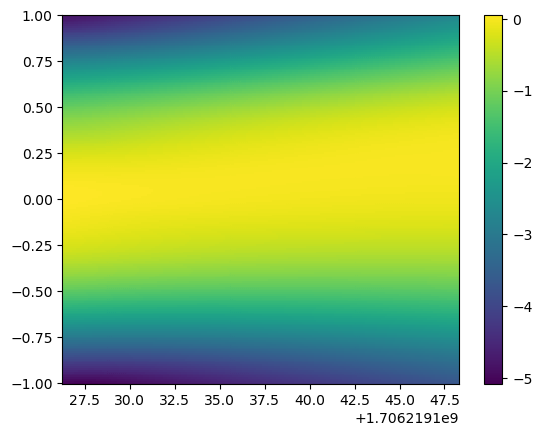

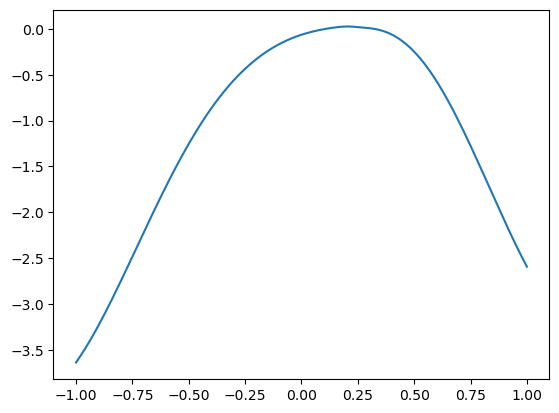

In [7]:
# plot the acquisition function
# note that target time is only updated during the generate call
target_time = X.generator.target_prediction_time
print(target_time-start_time)
my_acq_func = X.generator.get_acquisition(model)

with torch.no_grad():
    acq_pts = x.unsqueeze(-1).unsqueeze(-1)
    full_acq = my_acq_func.acq_func(gp_pts.unsqueeze(1))
    fixed_acq = my_acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(tt, xx, full_acq.reshape(n,n))
    fig.colorbar(c)

    fi2, ax2 = plt.subplots()
    ax2.plot(x.flatten(), fixed_acq.flatten())